In [1]:
# Cell 1: Setup - Import Libraries and Load Data
# Purpose: Import all required libraries for data handling, modeling, and visualization.
# Note: If running for the first time, uncomment and run the pip install commands below.

# Standard data handling and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Advanced modeling libraries
# Uncomment if not already installed:
# !pip install xgboost
# !pip install tensorflow
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# --- Load the dataset ---
# Assumes 'data.csv' is in the same directory.
try:
    data = pd.read_csv('data.csv')
    # Clean column names by stripping whitespace
    data.columns = data.columns.str.strip()
    print("✅ File 'data.csv' loaded successfully!")
    print("\nFirst 5 rows of the dataset:")
    print(data.head())
except FileNotFoundError:
    print("❌ Error: 'data.csv' not found. Please ensure the file is in the current directory.")
    
    # === NEW: RAW DATA VISUALIZATION ===
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x='Avg_Reaction_Time', y='Accuracy', alpha=0.8, s=80)
    plt.title("Raw Data Distribution")
    plt.grid(True)
    plt.savefig('Data_Visualize.jpg', dpi=300) 
    plt.show()
    
    print("Data loaded successfully! First 5 rows:")
    print(data.head())
except FileNotFoundError:
    print("Error: File not found")
    exit()

g:\code test\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
g:\code test\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
g:\code test\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime re

✅ File 'data.csv' loaded successfully!

First 5 rows of the dataset:
   Accuracy  Avg_Reaction_Time
0      89.0               2.20
1      83.0               1.89
2      90.0               1.28
3      93.0               2.00
4      84.0               1.30



STEP 1: MANUAL LABELING OF DATA

📊 Distribution of Manually Assigned Labels:
manual_label
Needs Improvement    7
Good Performer       6
Careful Performer    3
Name: count, dtype: int64

🖼️  Plotting label distribution...


C:\Users\Iftikher\AppData\Local\Temp\ipykernel_21232\672974349.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", edgecolor='black')


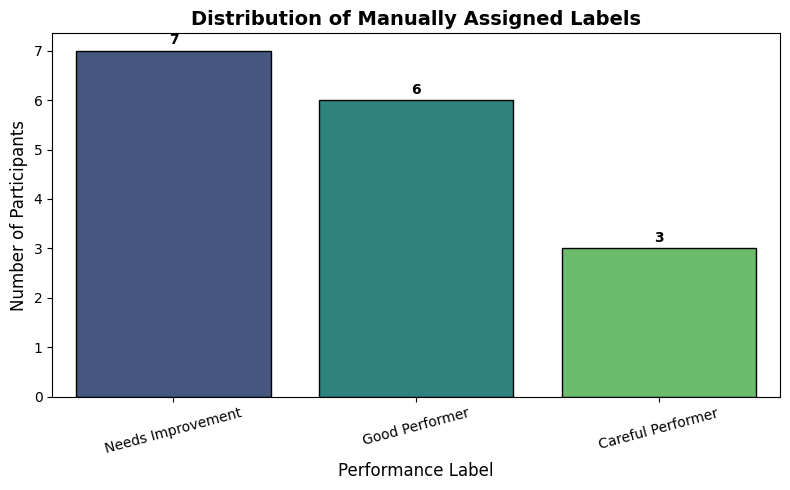


✅ Manual labeling completed. All classes have sufficient samples for modeling.


In [9]:
# Cell 2: Manual Labeling with Visualization
# Purpose: Assign meaningful labels based on domain logic and visualize their distribution.
# Strategy:
#   - 'Careful Performer': High accuracy but slow (>=2.5s) → cautious behavior
#   - 'Needs Improvement': Low accuracy (<90%) → inconsistent or rushed
#   - 'Good Performer': Others (likely balanced speed and accuracy)

print("\n" + "="*60)
print("STEP 1: MANUAL LABELING OF DATA")
print("="*60)

# Define conditions for labeling
conditions = [
    (data['Accuracy'] >= 90) & (data['Avg_Reaction_Time'] >= 2.5),  # Accurate but slow
    (data['Accuracy'] < 90)                                        # Inaccurate (needs work)
]

# Corresponding labels for each condition
choices = [
    'Careful Performer',
    'Needs Improvement'
]

# Apply labeling: Default is 'Good Performer' for remaining cases
data['manual_label'] = np.select(conditions, choices, default='Good Performer')

# Display label distribution
print("\n📊 Distribution of Manually Assigned Labels:")
label_counts = data['manual_label'].value_counts()
print(label_counts)

# --- New: Create a bar plot for label distribution ---
print("\n🖼️  Plotting label distribution...")

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", edgecolor='black')

# Add title and labels
plt.title("Distribution of Manually Assigned Labels", fontsize=14, fontweight='bold')
plt.xlabel("Performance Label", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)

# Rotate x-axis labels if needed
plt.xticks(rotation=15)

# Add value labels on top of each bar
for index, value in enumerate(label_counts.values):
    plt.text(index, value + max(label_counts.values)*0.01, str(value), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.savefig('Label_Distribution.jpg', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

# Confirm success
print("\n✅ Manual labeling completed. All classes have sufficient samples for modeling.")

In [3]:
# Cell 3: Feature Engineering
# Purpose: Create new statistical features to enhance model performance.
# New Features:
#   - Speed_Score: Inverse of reaction time (higher = faster)
#   - Performance_Ratio: Combines accuracy and speed into a single metric

print("\n" + "="*60)
print("STEP 2: FEATURE ENGINEERING")
print("="*60)

# Speed_Score: Higher value means faster response
data['Speed_Score'] = 1 / data['Avg_Reaction_Time']

# Performance_Ratio: Balances accuracy and speed
data['Performance_Ratio'] = data['Accuracy'] * data['Speed_Score']

# Define feature matrix (X) and target vector (y)
X = data[['Accuracy', 'Avg_Reaction_Time', 'Speed_Score', 'Performance_Ratio']]
y = data['manual_label']

# Display first few rows of engineered features
print("\n🔧 Newly Created Features (First 5 Rows):")
print(X.head())

print("\n✅ Feature engineering completed. Using 4 features for modeling.")


STEP 2: FEATURE ENGINEERING

🔧 Newly Created Features (First 5 Rows):
   Accuracy  Avg_Reaction_Time  Speed_Score  Performance_Ratio
0      89.0               2.20     0.454545          40.454545
1      83.0               1.89     0.529101          43.915344
2      90.0               1.28     0.781250          70.312500
3      93.0               2.00     0.500000          46.500000
4      84.0               1.30     0.769231          64.615385

✅ Feature engineering completed. Using 4 features for modeling.


In [4]:
# Cell 4: Data Preparation (Label Encoding & Stratified Split)
# Purpose: Prepare data for modeling.
# Steps:
#   - Encode text labels into integers
#   - Split data into train/test sets with stratification

print("\n" + "="*60)
print("STEP 3: DATA PREPARATION")
print("="*60)

# Initialize label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Show mapping of labels to numbers
print("\n🏷️  Label Encoding Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"   {class_name} → {i}")

# Split  80% training, 20% testing, with class balance preserved
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # Ensures balanced distribution across splits
)

print(f"\n📏 Dataset Split Summary:")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples : {len(X_test)}")
print("✅ Data preparation completed.")


STEP 3: DATA PREPARATION

🏷️  Label Encoding Mapping:
   Careful Performer → 0
   Good Performer → 1
   Needs Improvement → 2

📏 Dataset Split Summary:
   Training samples: 12
   Testing samples : 4
✅ Data preparation completed.



MODEL 1: RANDOM FOREST CLASSIFIER

📋 Random Forest - Classification Report:
                   precision    recall  f1-score   support

Careful Performer       1.00      1.00      1.00         1
   Good Performer       1.00      1.00      1.00         1
Needs Improvement       1.00      1.00      1.00         2

         accuracy                           1.00         4
        macro avg       1.00      1.00      1.00         4
     weighted avg       1.00      1.00      1.00         4


🖼️  Random Forest - Confusion Matrix:


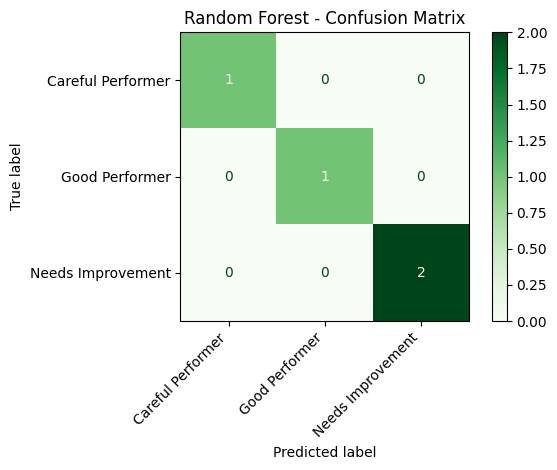

✅ Random Forest model trained and evaluated.


In [5]:
# Cell 5: Apply Random Forest Algorithm
# Purpose: Train and evaluate Random Forest classifier.

print("\n" + "="*60)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("="*60)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation: Classification report
print("\n📋 Random Forest - Classification Report:")
print(classification_report(
    y_test, y_pred_rf,
    target_names=label_encoder.classes_,
    zero_division=0
))

# Confusion Matrix Visualization
print("\n🖼️  Random Forest - Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(
    rf_model, X_test, y_test,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Greens
)
plt.xticks(rotation=45, ha='right')
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.savefig('Random_Forest_Confusion_Matrix.jpg', dpi=300)
plt.show()

print("✅ Random Forest model trained and evaluated.")


MODEL 2: XGBOOST CLASSIFIER


g:\code test\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:52:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📋 XGBoost - Classification Report:
                   precision    recall  f1-score   support

Careful Performer       1.00      1.00      1.00         1
   Good Performer       1.00      1.00      1.00         1
Needs Improvement       1.00      1.00      1.00         2

         accuracy                           1.00         4
        macro avg       1.00      1.00      1.00         4
     weighted avg       1.00      1.00      1.00         4


🖼️  XGBoost - Confusion Matrix:


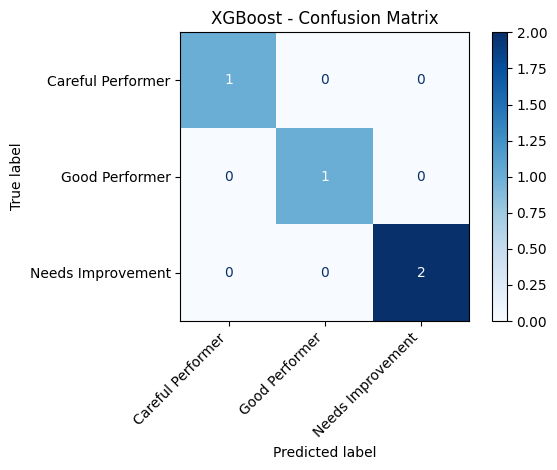

✅ XGBoost model trained and evaluated.


In [6]:
# Cell 6: Apply XGBoost Algorithm
# Purpose: Train and evaluate XGBoost classifier.

print("\n" + "="*60)
print("MODEL 2: XGBOOST CLASSIFIER")
print("="*60)

# Initialize and train the model
# Disable default label encoder to avoid warnings with multi-class
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation: Classification report
print("\n📋 XGBoost - Classification Report:")
print(classification_report(
    y_test, y_pred_xgb,
    target_names=label_encoder.classes_,
    zero_division=0
))

# Confusion Matrix Visualization
print("\n🖼️  XGBoost - Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(
    xgb_model, X_test, y_test,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues
)
plt.xticks(rotation=45, ha='right')
plt.title("XGBoost - Confusion Matrix")
plt.tight_layout()
plt.savefig('XGBoost_Confusion_Matrix.jpg', dpi=300)
plt.show()

print("✅ XGBoost model trained and evaluated.")


MODEL 3: NEURAL NETWORK (FEEDFORWARD)
🧠 Training Neural Network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

📋 Neural Network - Classification Report:
                   precision    recall  f1-score   support

Careful Performer       0.25      1.00      0.40         1
   Good Performer       0.00      0.00      0.00         1
Needs Improvement       0.00      0.00      0.00         2

         accuracy                           0.25         4
        macro avg       0.08      0.33      0.13         4
     weighted avg       0.06      0.25      0.10         4


🖼️  Neural Network - Confusion Matrix:


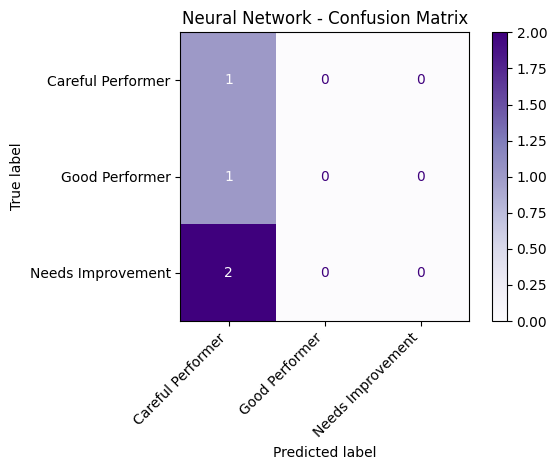

✅ Neural Network model trained and evaluated.


In [7]:
# Cell 7: Apply Neural Network Algorithm
# Purpose: Build, train, and evaluate a simple feedforward neural network.

print("\n" + "="*60)
print("MODEL 3: NEURAL NETWORK (FEEDFORWARD)")
print("="*60)

# Get input dimensions dynamically
n_features = X_train.shape[1]
n_classes = len(label_encoder.classes_)

# Build model architecture
nn_model = Sequential([
    Input(shape=(n_features,)),           # Input layer
    Dense(16, activation='relu'),         # Hidden layer 1
    Dense(8, activation='relu'),          # Hidden layer 2
    Dense(n_classes, activation='softmax') # Output layer (softmax for multi-class)
])

# Compile model
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # For integer labels
    metrics=['accuracy']
)

# Train the model (quietly, to avoid clutter)
print("🧠 Training Neural Network...")
nn_model.fit(X_train, y_train, epochs=10, batch_size=4, verbose=0)

# Predict probabilities and get predicted classes
y_pred_nn_probs = nn_model.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn_probs, axis=1)

# Evaluation: Classification report
print("\n📋 Neural Network - Classification Report:")
print(classification_report(
    y_test, y_pred_nn,
    target_names=label_encoder.classes_,
    zero_division=0
))

# Confusion Matrix Visualization
print("\n🖼️  Neural Network - Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_nn,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Purples
)
plt.xticks(rotation=45, ha='right')
plt.title("Neural Network - Confusion Matrix")
plt.tight_layout()
plt.savefig('Neural_Network_Confusion_Matrix.jpg', dpi=300)
plt.show()

print("✅ Neural Network model trained and evaluated.")